# Linear Regression from scratch

The first model that we are going to implement is linear regression

Linear regression is the most simple model in machine learning so I think is a good starting point. We will we using mean squared error as metric and cost function and also batch gradient descent as optimization algorithm.

We are going to use California house-prices dataset from Scikit-learn, data description [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing)  



In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import datasets 
import matplotlib.pyplot as plt
import pandas as pd

Loading the data as a dataframe to do some EDA first

In [2]:
data = datasets.fetch_california_housing(as_frame=True)


In [3]:
housing = data.frame
housing

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


We can see that we have 20640 instances and 8 features plus the target value.

Now let's see if we have missing values

In [4]:
housing.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

No missing values.

Now let's check some basic statistical data

In [5]:
housing.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


Looks like we have some outliers in AveBedrms, AveRooms, AveOccup, those max values seem weird, but to be sure we should do boxplots

Text(0.5, 1.0, 'AveOccup')

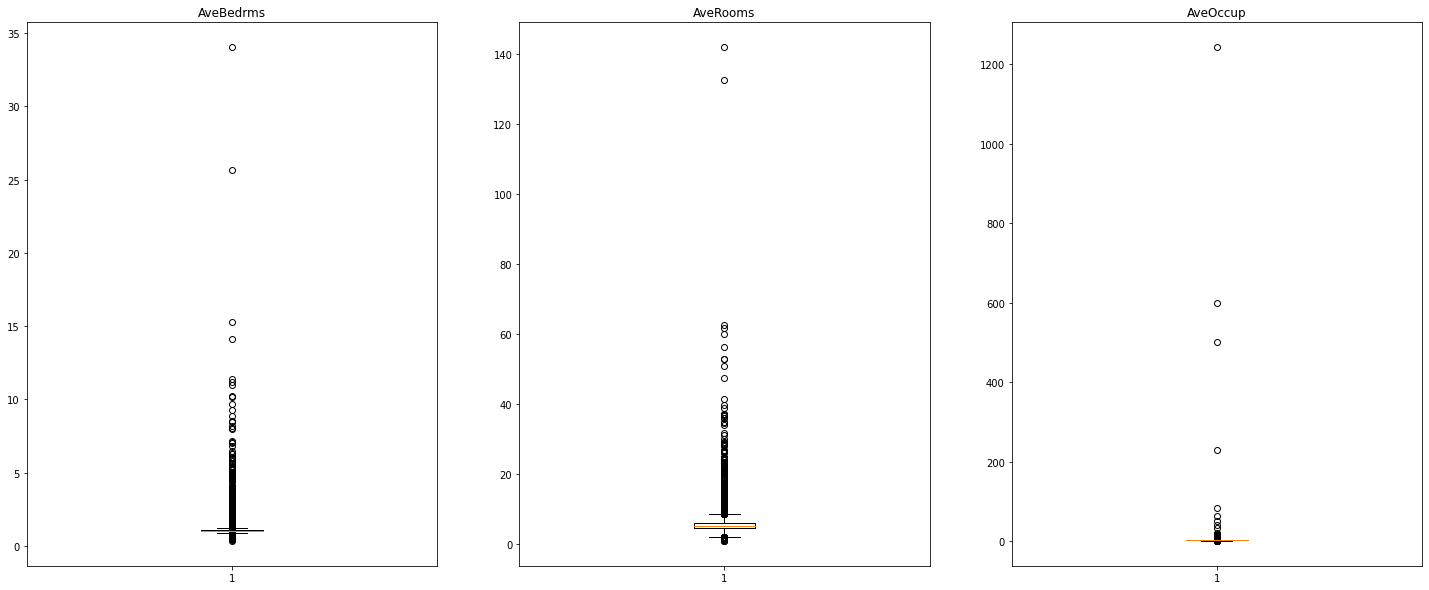

In [6]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (25,10))

ax1.boxplot(housing['AveBedrms'])
ax1.set_title('AveBedrms')

ax2.boxplot(housing['AveRooms'])
ax2.set_title('AveRooms')

ax3.boxplot(housing['AveOccup'])
ax3.set_title('AveOccup')

Looks like we have a lot of outliers. Let's remove all of them

We are going to remove them using the Z score by setting a threshold of 3 standard deviations, so any number that goes beyond that is going to be removed

In [7]:
from scipy import stats
#setting threshold
threshold = 3

#Getting Z scores
z_scores = np.abs(stats.zscore(housing))
#Matching z_scores greater than threshold
outlier = z_scores > threshold

#Applying mask
result = np.where(outlier == 1)

#Getting the indexes
idx = list(result[0])

#Droping outliers from DataFrame
housing.drop(idx,inplace = True)




In [8]:
housing

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


We came out with 19794 instances. Now let's plot some box plots to see the difference

In [9]:
housing.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,19794.000000,19794.000000,19794.000000,19794.000000,19794.000000,19794.000000,19794.000000,19794.000000,19794.000000
mean,3.732421,28.971658,5.243471,1.068965,1344.441598,2.931222,35.636131,-119.583137,2.025858
std,1.604571,12.448220,1.221588,0.135362,811.791606,0.884634,2.137114,2.003830,1.107571
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.750000,32.540000,-124.350000,0.149990
25%,2.544400,19.000000,4.417435,1.005442,792.000000,2.426490,33.930000,-121.800000,1.184000
50%,3.500000,29.000000,5.185518,1.048193,1162.000000,2.816485,34.260000,-118.500000,1.781000
75%,4.661250,37.000000,5.970846,1.098284,1696.000000,3.284288,37.720000,-118.020000,2.600750
max,9.556100,52.000000,12.447368,2.514610,4819.000000,33.952941,41.950000,-114.550000,5.000010


Text(0.5, 1.0, 'AveOccup')

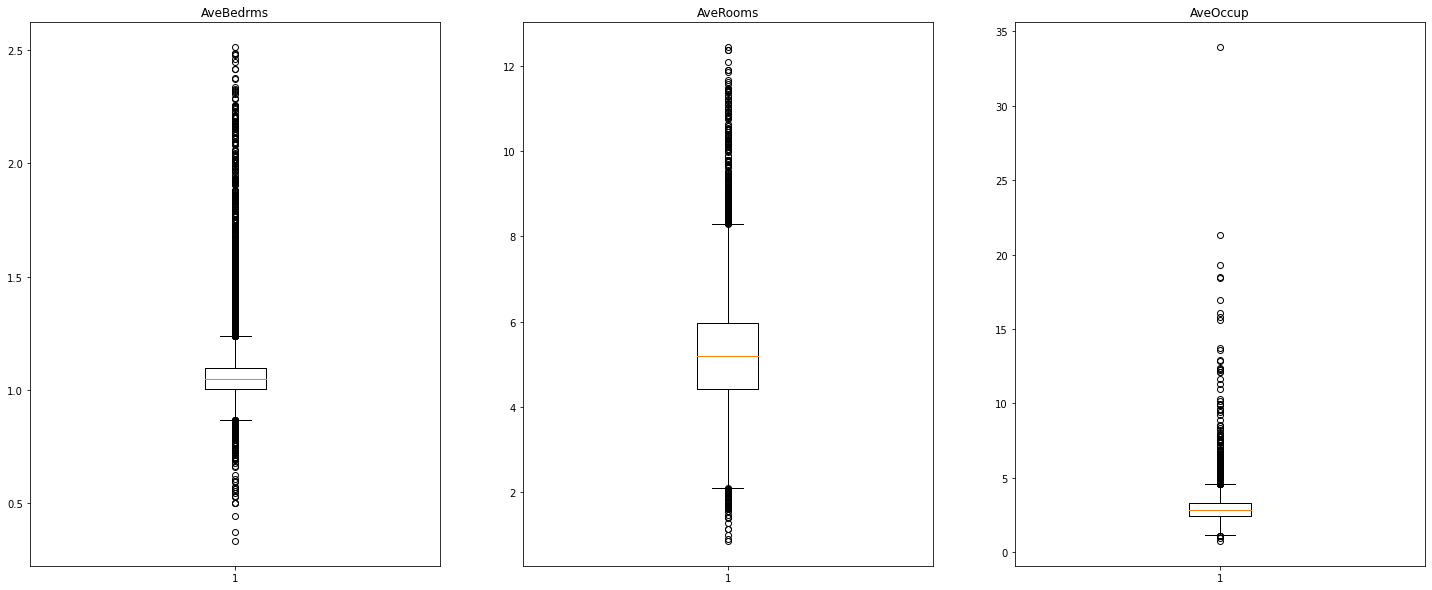

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (25,10))

ax1.boxplot(housing['AveBedrms'])
ax1.set_title('AveBedrms')

ax2.boxplot(housing['AveRooms'])
ax2.set_title('AveRooms')

ax3.boxplot(housing['AveOccup'])
ax3.set_title('AveOccup')


That is a little bit better. We still have some outliers but not it is not that critical. We will create a first model quickly and gain some insights to improve performance


Now we will prepare the data to enter the ML algorithm.



We need a few things before

1. Normalize the inputs 
2. Transform pandas dataframes into arrays
3. Create training and test sets
4. Evaluate the results using Mean absolute error




In [11]:
y = housing['MedHouseVal']
housing.drop('MedHouseVal',axis = 1,inplace = True)


In [12]:
X = housing
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


For our first aproach we are going to use only 1000 instances and the variable MedInc to simplify visualizations 

In [13]:
X_initial = X['MedInc'].loc[:1000]
y_initial = y.loc[:1000]

Let's plot the variable

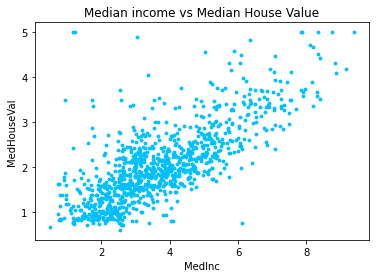

In [14]:
plt.scatter(X_initial,y_initial,color='deepskyblue',s = 8)
plt.xlabel('MedInc')
plt.ylabel('MedHouseVal')
plt.title('Median income vs Median House Value')
plt.show()

Now, we need to normalize the inputs first by subtracting the mean and dividing by the standard deviation

In [15]:
def normalize(data):
    mean = data.mean()
    std = data.std()
    norm = (data - mean) / std
    return norm
X_norm = normalize(X_initial)

Creating the input arrays

In [16]:
X_arr = np.array(X_norm)
y_arr = np.array(y_initial)

Creating training and test sets

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X_arr,y_arr,test_size = 0.2,random_state = 0)

In [19]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((782,), (196,), (782,), (196,))

In python we need to reshape the arrays to avoid future bugs due to that comma at the end of the number

We want specific array shapes like (782,1)

In [20]:
def reshape(X_train,X_test,y_train,y_test):
    X_train_reshaped = np.reshape(X_train,(X_train.shape[0],1))
    
    X_test_reshaped  = np.reshape(X_test,(X_test.shape[0],1))

    y_train_reshaped = np.reshape(y_train,(y_train.shape[0],1))

    y_test_reshaped  = np.reshape(y_test,(y_test.shape[0],1))
    
    return X_train_reshaped, X_test_reshaped, y_train_reshaped ,y_test_reshaped

In [21]:
X_train_reshaped,X_test_reshaped,y_train_reshaped,y_test_reshaped = reshape(X_train,X_test,y_train,y_test)

In [22]:
X_train_reshaped.shape,X_test_reshaped.shape,y_train_reshaped.shape,y_test_reshaped.shape

((782, 1), (196, 1), (782, 1), (196, 1))

Perfect! our arrays are ready

-----------------------------

### Now it's time to create the model

First, notation and equations that we are going to use in the code



**Notation:**

$\alpha = Learning$ $rate$

$MSE = $ $Mean$ $squared$ $error$ 

$\nabla_{\theta} = Gradient$

$m = Length$ $of$ $the$ $training$ $set$

$\theta = theta$ $parameters$

-----------------------------


**Equations:**

**Model prediction** 

$\hat{y} = \theta_0 x_0 + \theta_1  x_1 + \theta_2 x_2 \dots \theta_n x_n $

**Hypothesis function. Model prediction equation vectorized**

$
h(x) = \theta \cdot X
$

**Cost Function**

$MSE = \frac{1}{m} \sum_{i=1}^m{(h(x) - y)^2}$

**Gradient**

$\nabla_{\theta (MSE)} \to \frac{\partial}{\partial \theta} = \frac{2}{m}\sum_{i=1}^m ({h(x) - y})x$

**Vectorized Gradient**

$\nabla_{\theta (MSE)}$  $ = \frac{2}{m} \cdot X^T (X \cdot \theta - y)$

**Update theta**

$\theta = \theta - \alpha \cdot \nabla_{\theta(MSE)}$



In [23]:
"""

        In the first place we are going to define our training function.
        We will call it 'fit' to be consistent with scikit learn.  
        
        The function parameters will be the train data, labels, and the
        desired number of iterations. It will return the theta parameters to
        be used for prediction

"""

def fit(X_train,y_train,iterations,learning_rate):
        #Retrieving m
        m_train = X_train.shape[0]
        
        #Adding X0 = 1 to the training set 
        X_train_bias = np.c_[np.ones(m_train),X_train]
        
        #Retrieving the number of features
        n = X_train_bias.shape[1]
        
        #Randomly initialize theta
        theta = np.random.randn(n,1)
        
        #Keep track of cost values
        cost = []
        
        #Iterate
        for i in range(iterations):
            
            #Compute hypothesis function
            h = np.dot(X_train_bias,theta)
            
            #Measure error
            error = h - y_train
            
            #Compute the cost function
            J = (1/m_train)*np.sum(error**2)
            
            #Compute the gradients
            grad = (2/m_train)*np.dot(X_train_bias.T,error)
            
            #Update theta values
            theta = theta - learning_rate*grad
            
            #add current cost value
            cost.append(J)
         
        #Plot the cost values
        plt.plot(cost)
        plt.xlabel('Iterations')
        plt.ylabel('MSE')
        plt.show()
        
        return theta

In [24]:
"""

        Now, the prediction function.
        It will enter the theta values from training and the test data
        and will output the predictions


"""

def predict(X_test,theta):
        
        #retrieve the test set lenght 
        m_test = X_test.shape[0]
        
        #Adding X0 = 1 to test set
        X_test_bias = np.c_[np.ones(m_test),X_test]
        
        #Calculate the prediction
        pred = np.dot(X_test_bias,theta)
        return pred

### Let's test our functions!

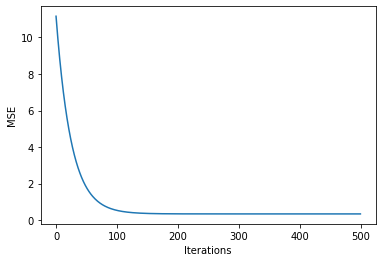

array([[2.07183501],
       [0.62423139]])

In [25]:
theta = fit(X_train_reshaped,y_train_reshaped,iterations = 500,learning_rate = 0.01)
theta

Great! Our training was succesful, the cost function converged

Now let's make predictions, plot the data, and evaluate mean squared error

In [26]:
y_pred = predict(X_test_reshaped,theta)

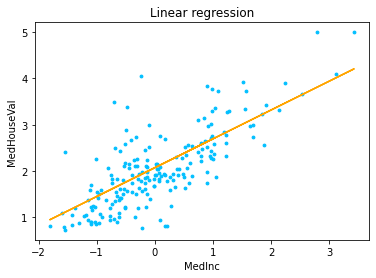

In [27]:
plt.scatter(X_test_reshaped,y_test_reshaped,color='deepskyblue',s = 8)
plt.plot(X_test_reshaped,y_pred,color = 'orange')
plt.xlabel('MedInc')
plt.ylabel('MedHouseVal')
plt.title('Linear regression')
plt.show()

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [29]:
#Create scikit learn model

model = LinearRegression()
model.fit(X_train_reshaped,y_train_reshaped)

LinearRegression()

Now let's compare linear regression from scikit learn with our custom approach to see the difference

Compare both of them using MSE from sklearn

In [30]:
#Compute prediction in each model
pred_sklearn = model.predict(X_test_reshaped)
pred_custom = predict(X_test_reshaped,theta)

#Compute the error from each model
error_sklearn = mean_squared_error(y_test_reshaped,pred_sklearn)
custom_error = mean_squared_error(y_test_reshaped,pred_custom)

In [31]:
print('Error in test set from scikit-learn model:',error_sklearn)
print('Error in test from our custom model:',custom_error)

Error in test set from scikit-learn model: 0.29280295679642887
Error in test from our custom model: 0.29279018345996327


It works fine. Now let's try the model in the whole dataset and compare it again with sklearn

But this time we are going to compile everything in one class

In [32]:
"""
    It will take two initial arguments:
        * Iterations
        * learning_rate

    * The fit method will train the model
    * The predict method will compute the parameters in the test data
"""

class linear_regression:
    def __init__(self,iterations,learning_rate):
        self.iterations = iterations
        self.learning_rate = learning_rate
        pass   
    #Training method
    def fit(self,X_train,y_train):
        #Retrieving m
        m_train = X_train.shape[0]
        #Adding X0 = 1 to the training set 
        X_train_bias = np.c_[np.ones(m_train),X_train]
        #Retrieving the number of features
        n = X_train_bias.shape[1]
        #Randomly initialize theta
        theta = np.random.randn(n,1)
        #Keep track of cost values
        cost = []
        
        #Loop over the number of iterations
        for i in range(self.iterations):
            #Compute hypothesis function
            h = np.dot(X_train_bias,theta)
            #Measure error
            error = h - y_train
            
            #Compute the cost
            J = (1/m_train)*np.sum(error**2)
            
            #Compute the gradiente
            grad = (2/m_train)*np.dot(X_train_bias.T,error)
            
            #Update theta values
            theta = theta - self.learning_rate*grad
            #add current cost value
            cost.append(J)
         
        #Plot the cost values
        plt.plot(cost)
        plt.xlabel('Iterations')
        plt.ylabel('MSE')
        plt.show()
        
        return theta
    
    def predict(self,X_test,theta):
        
        #retrieve the test set lenght 
        m_test = X_test.shape[0]
        
        #Adding X0 = 1 to test set
        X_test_bias = np.c_[np.ones(m_test),X_test]
        
        #Calculate the prediction
        pred = np.dot(X_test_bias,theta)
        return pred

In [33]:
#as we have more features, we will double the number of iterations
custom_model = linear_regression(iterations = 1000,learning_rate = 0.01)

In [34]:
#Normalize and convert into array
X_full = normalize(housing)
X_arr_full = np.array(X_full)
y_arr_full = np.array(y)

#Generate train and test sets
X_train_full,X_test_full,y_train_full,y_test_full = train_test_split(X_arr_full,y_arr_full,test_size = 0.2,random_state = 0)

In [35]:
#Reshape data 

y_train_reshaped = np.reshape(y_train_full,(y_train_full.shape[0],1))
y_test_reshaped = np.reshape(y_test_full,(y_test_full.shape[0],1))

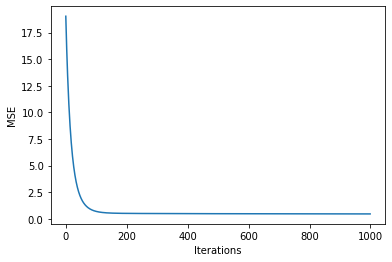

In [36]:
#Train custom model
theta_full = custom_model.fit(X_train_full,y_train_reshaped)

In [37]:
model.fit(X_train_full,y_train_reshaped)

LinearRegression()

In [38]:
#Compute predictions
pred_sklearn = model.predict(X_test_full)
pred_custom = custom_model.predict(X_test_full,theta_full)

#Compute errors
error_sklearn = mean_squared_error(y_test_reshaped,pred_sklearn)
error_custom = mean_squared_error(y_test_reshaped,pred_custom)

In [39]:
print('Error in test set from scikit-learn model:',error_sklearn)
print('Error in test from our custom model:',error_custom)

Error in test set from scikit-learn model: 0.4493677461790718
Error in test from our custom model: 0.46234596734400846


The errors are similar, so our model from scratch is doing a similar work that scikit-learn model

In [20]:
#Load data
data = datasets.load_breast_cancer()
X = data['data']
y = data['target']


In [21]:
#np.random.seed(0)
m,n = X.shape
theta = np.random.randn(n) # initialization of theta

#add bias terms to X and theta
X_with_bias = np.c_[np.ones(m),X] 
theta_with_bias = np.insert(theta,0,0)

In [22]:
#Split Data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_with_bias,y,test_size = 0.25)


In [23]:
#Scaling X

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [24]:
#Define Sigmoid function
def sigmoid(x):
    z = 1/(1 + np.exp(-x)) 
    return z


In [25]:
##Function for training data
def log_reg(theta,X,y,alpha):
    cost = []
    for i in range(2000):
        h = np.dot(X,theta)
        z = sigmoid(h)    
        J = (-1/m)*np.sum(y*np.log(z)+(1-z)*np.log(1-z))
        cost.append(J)
        error = z - y
        grad = (1/m)*np.sum(error*X.T)
        theta =  theta - grad*alpha
        if i % 500 == 0:
            print(i, J)
    pred = (z>=0.5).astype(int)
    return pred,theta,cost

In [26]:
#Training the data
pred_train, theta,cost = log_reg(theta_with_bias,X_train_scaled,y_train,0.001)


0 1.2303668639724783
500 0.6017461263633724
1000 0.5962569935584212
1500 0.5953874352082311


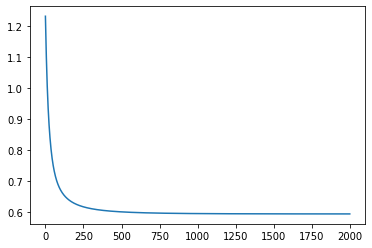

In [27]:
#Plotting Cost FUnction to see if it is working properly
plt.plot(cost)
plt.show()

In [28]:
from sklearn.metrics import accuracy_score

In [29]:
test_pred = sigmoid(np.dot(theta,X_test_scaled.T))
test_pred = (test_pred>=0.5).astype(int)

In [30]:
acc_train = accuracy_score(y_train,pred_train)
acc_train

0.8051643192488263

In [31]:
acc_test = accuracy_score(y_test,test_pred)
acc_test

0.7762237762237763

In [32]:
test_pred

array([1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0])